In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import zipfile
import os
from google.colab import drive
from torchsummary import summary

In [9]:
#Check for GPU and Intialization of Batch_Size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ",device)
batch_num = 64

Device :  cuda


In [10]:
#Importing dataset from Google Drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/cnn_dataset.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:

     zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#Transformations to be applied to every Image present in the dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)), #Resize images to a 224x224 size for VGG
    transforms.Grayscale(num_output_channels=1), #Convert the images to grayscale (1 channel) because the images are b/w
    transforms.ToTensor(), #Convert into PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  #Normalization
])

#Dataset Loading
dataset = datasets.ImageFolder(root=os.path.join(extract_path, 'cnn_dataset'), transform=transform)

In [13]:
#Splitting dataset in to Training, Validation and Testing
total_data = len(dataset)
train_data = int(0.7 * total_data)
val_data = int(0.15 * total_data)
test_data = total_data - train_data - val_data

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_data, val_data, test_data])

train_loader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_num, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_num, shuffle=False)

print('Training Data : ',train_data)
print('\nValidation Data : ',val_data)
print('\nTesting Data : ',test_data)

Training Data :  70560

Validation Data :  15120

Testing Data :  15120


In [14]:
#Analysis of the dataset
#Creating Data Loader
data_loader = DataLoader(dataset, batch_size=batch_num, shuffle=True)
images, labels = next(iter(data_loader))
image_shape = images[0].shape
print("Image Shape : ",image_shape)

num_of_channels = images[0].shape[0]
size_of_image = images[0].shape[1]

print("\nNumber of Channels : ",num_of_channels)
print("\nSize of Image : {}x{}".format(size_of_image, size_of_image))

Image Shape :  torch.Size([1, 224, 224])

Number of Channels :  1

Size of Image : 224x224


In [17]:
#VGG11 Model Architecture
class VGG_11(nn.Module):

    def __init__(self, num_classes=36):

        super(VGG_11, self).__init__()

        self.features = nn.Sequential(

            nn.Conv2d(1, 64, kernel_size=3, padding=1), # Conv3-64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Conv3-128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Conv3-256
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Conv3-256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Conv3-512
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv3-512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv3-512
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv3-512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(

            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [18]:
#Summary of Model
model = VGG_11(num_classes=36).to(device)
summary(model, (1, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [19]:
#model = VGG_11(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss() #Loss Function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #Optimizer

#Lists to store Accuracy
Accuracy_List_Training = []
Accuracy_List_Validation = []
Accuracy_List_Testing = []

#Lists to store Loss
Loss_List_Training = []
Loss_List_Validation = []
Loss_List_Testing = []

#Training

start_time = time.time()
iterations = 10

for iteration in range(iterations):

    print("\nTraining Iteration ({0}/{1}) :".format((iteration + 1),(iterations)))

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = 100.0 * correct_train / total_train
    Accuracy_List_Training.append(train_accuracy)
    train_loss = running_loss / len(train_loader)
    Loss_List_Training.append(train_loss)

    print(f"Training Loss: {train_loss},Training Accuracy: {train_accuracy}%")

   # Validation

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():

        for images, labels in val_loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

        val_accuracy = 100.0 * correct_val / total_val
        Accuracy_List_Validation.append(val_accuracy)
        validation_loss = val_loss / len(val_loader)
        Loss_List_Validation.append(validation_loss)

        print(f"Validation Loss: {validation_loss}, Validation Accuracy: {val_accuracy}%")

end_time = time.time()

print(f"\nTraining Time: {end_time - start_time} seconds")

print("\nFinished Training!")


#Testing

model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

all_preds = []
all_labels = []

with torch.no_grad():

    for images, labels in test_loader:

        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100.0 * correct_test / total_test
Accuracy_List_Testing.append(test_accuracy)
Accuracy_List_Testing = Accuracy_List_Testing * iterations
test_loss = test_loss / len(test_loader)
Loss_List_Testing.append(test_loss)
Loss_List_Testing = Loss_List_Testing * iterations

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro') #Metrics

print(f"\nTest Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

print(f"\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}")


Training Iteration (1/10) :
Training Loss: 3.584051024340978,Training Accuracy: 2.619047619047619%
Validation Loss: 3.584421411345277, Validation Accuracy: 2.6984126984126986%

Training Iteration (2/10) :
Training Loss: 2.3762472159789025,Training Accuracy: 33.900226757369616%
Validation Loss: 0.37983040172087995, Validation Accuracy: 86.72619047619048%

Training Iteration (3/10) :
Training Loss: 0.37272529459388715,Training Accuracy: 86.70351473922902%
Validation Loss: 0.28282247835825264, Validation Accuracy: 89.755291005291%

Training Iteration (4/10) :
Training Loss: 0.2687660773248426,Training Accuracy: 89.81292517006803%
Validation Loss: 0.25294432320675264, Validation Accuracy: 90.76719576719577%

Training Iteration (5/10) :
Training Loss: 0.2286534551243996,Training Accuracy: 91.06434240362812%
Validation Loss: 0.24184240297048906, Validation Accuracy: 91.36243386243386%

Training Iteration (6/10) :
Training Loss: 0.1987960458524586,Training Accuracy: 91.96428571428571%
Valida

In [20]:
#Saving Model
torch.save(model.state_dict(), "apatra2_yashdatt_assignment2_part4.h5")
print("Saved !")

Saved !


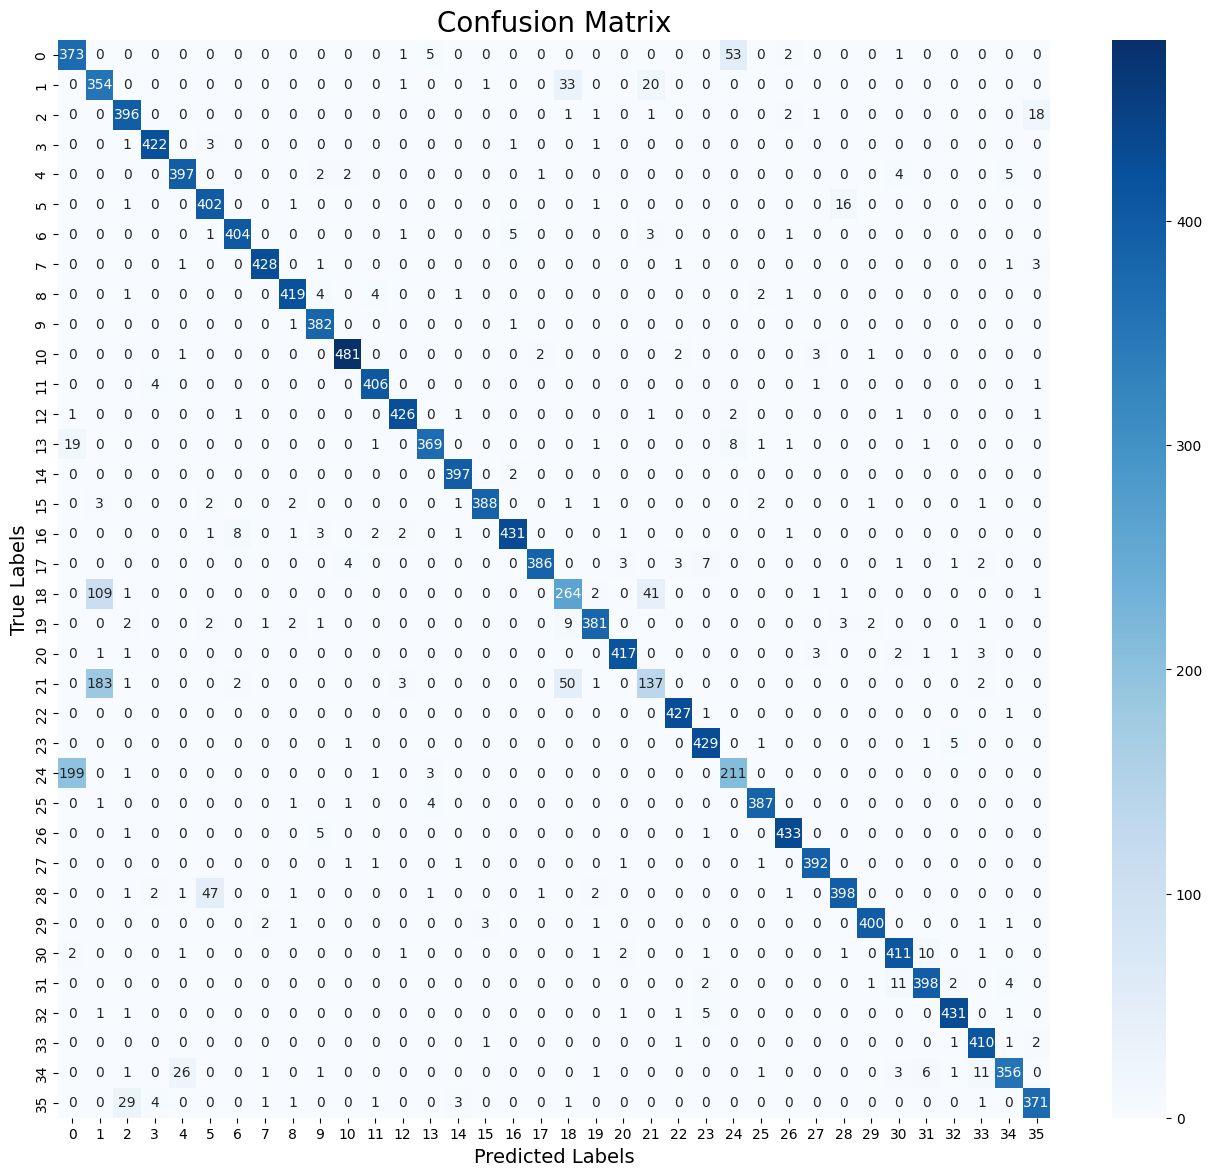

In [21]:
#Confusion Matrix
ConfusionMatrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))

sns.heatmap(ConfusionMatrix, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels', fontsize = 14)
plt.ylabel('True Labels', fontsize = 14)
plt.title('Confusion Matrix', fontsize = 20)

plt.show()

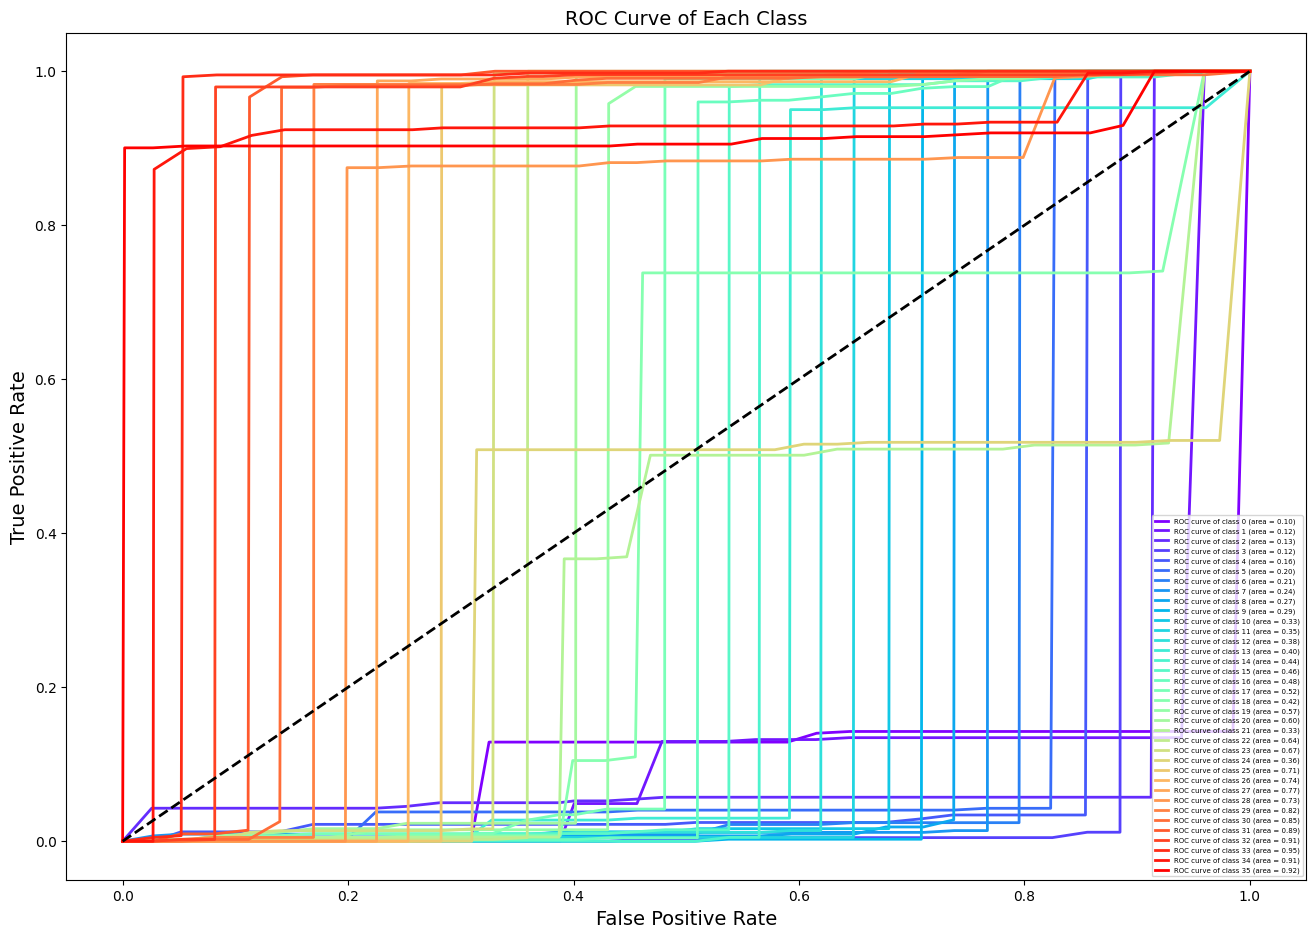

In [22]:
#ROC Curve
binarized_labels = label_binarize(all_labels, classes=list(range(36)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(36):

    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_preds)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 11))

for i, color in zip(range(36), plt.cm.rainbow(np.linspace(0, 1, 36))):

    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve of Each Class', fontsize=14)

plt.legend(loc="lower right", fontsize=5)

plt.show()

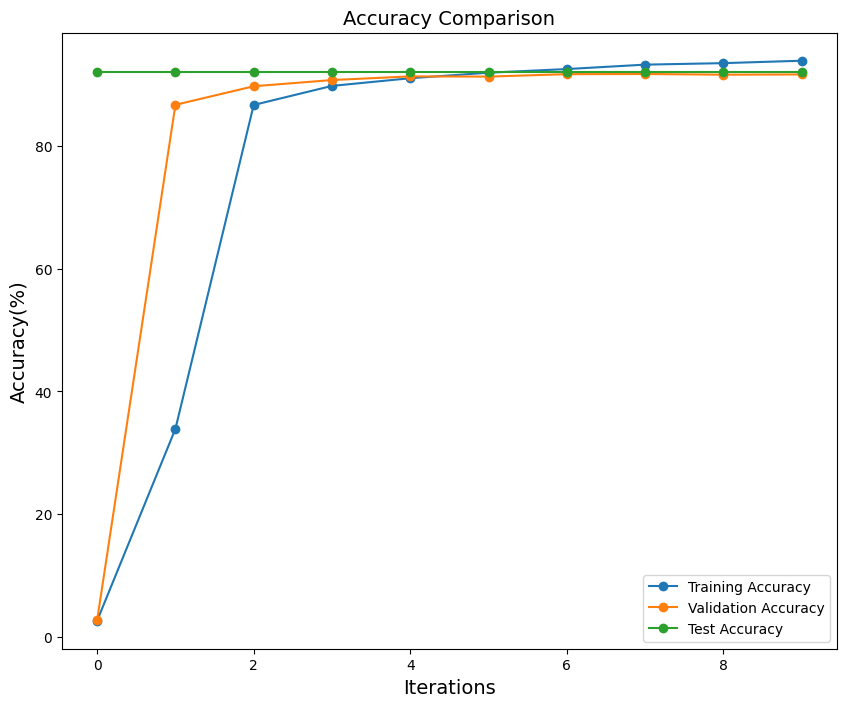

In [23]:
#Accuracy Graph
plt.figure(figsize=(10, 8))

plt.plot(Accuracy_List_Training, marker='o', label='Training Accuracy')
plt.plot(Accuracy_List_Validation, marker='o', label='Validation Accuracy')
plt.plot(Accuracy_List_Testing, marker='o', label='Test Accuracy')

plt.title('Accuracy Comparison', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Accuracy(%)', fontsize=14)

plt.legend()

plt.show()

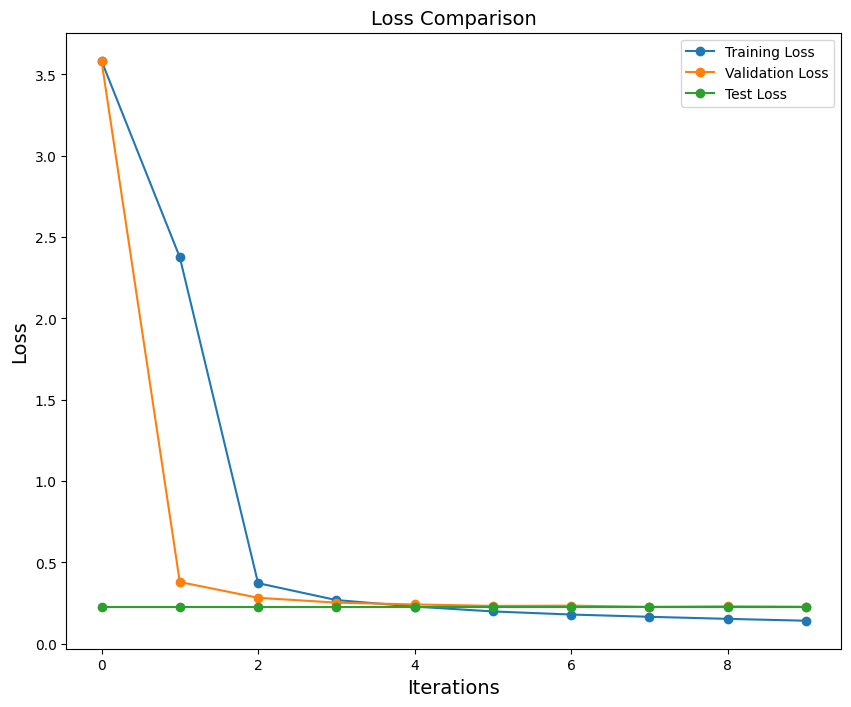

In [24]:
#Loss Graph
plt.figure(figsize=(10, 8))

plt.plot(Loss_List_Training, marker='o', label='Training Loss')
plt.plot(Loss_List_Validation, marker='o', label='Validation Loss')
plt.plot(Loss_List_Testing, marker='o', label='Test Loss')

plt.title('Loss Comparison', fontsize=14)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend()

plt.show()